In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib as plt
import seaborn
import re
import statsmodels.formula.api

from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
%matplotlib inline
seaborn.set_context('notebook', rc={'figure.figsize': (10, 6)}, font_scale=1.5)

In [4]:
def load_embeddings(filename):
    """
    Load a DataFrame from the generalized text format used by word2vec, GloVe,
    fastText, and ConceptNet Numberbatch. The main point where they differ is
    whether there is an initial line with the dimensions of the matrix.
    """
    labels = []
    rows = []
    with open(filename, encoding='utf-8') as infile:
        for i, line in enumerate(infile):
            items = line.rstrip().split(' ')
            if len(items) == 2:
                # This is a header row giving the shape of the matrix
                continue
            labels.append(items[0])
            values = np.array([float(x) for x in items[1:]], 'f')
            rows.append(values)
    
    arr = np.vstack(rows)
    return pd.DataFrame(arr, index=labels, dtype='f')

embeddings = load_embeddings('Desktop\data/glove.42B.300d.txt')
embeddings.shape

(1917494, 300)

In [5]:
def load_lexicon(filename):
    """
    Load a file from Bing Liu's sentiment lexicon
    (https://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html), containing
    English words in Latin-1 encoding.
    
    One file contains a list of positive words, and the other contains
    a list of negative words. The files contain comment lines starting
    with ';' and blank lines, which should be skipped.
    """
    lexicon = []
    with open(filename, encoding='latin-1') as infile:
        for line in infile:
            line = line.rstrip()
            if line and not line.startswith(';'):
                lexicon.append(line)
    return lexicon

pos_words = load_lexicon('Desktop\data/positive-words.txt')
neg_words = load_lexicon('Desktop\data/negative-words.txt')

In [6]:
pos_vectors = embeddings.loc[pos_words].dropna()
neg_vectors = embeddings.loc[neg_words].dropna()

In [7]:
vectors = pd.concat([pos_vectors, neg_vectors])
targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
labels = list(pos_vectors.index)+list(neg_vectors.index)

In [8]:
train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
    train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)

In [9]:
model = SGDClassifier(loss='log', random_state=0, tol=100)
model.fit(train_vectors, train_targets)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=0, shuffle=True,
       tol=100, verbose=0, warm_start=False)

In [10]:
accuracy_score(model.predict(test_vectors), test_targets)

0.92156862745098034

In [11]:
def vecs_to_sentiment(vecs):
    # predict_log_proba gives the log probability for each class
    predictions = model.predict_log_proba(vecs)

    # To see an overall positive vs. negative classification in one number,
    # we take the log probability of positive sentiment minus the log
    # probability of negative sentiment.
    return predictions[:, 1] - predictions[:, 0]


def words_to_sentiment(words):
    vecs = embeddings.loc[words].dropna()
    log_odds = vecs_to_sentiment(vecs)
    return pd.DataFrame({'sentiment': log_odds}, index=vecs.index)


# Show 20 examples from the test set
words_to_sentiment(test_labels).iloc[:20]

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


,sentiment
fidgety,-33.015758
interrupt,-56.021609
staunch,15.887149
improperly,-60.510503
taxing,-7.018846
works,inf
low-cost,inf
disapointment,-45.918031
shortcomings,-22.290683
belittling,-49.914711


In [12]:
import re
TOKEN_RE = re.compile(r"\w.*?\b")
# The regex above finds tokens that start with a word-like character (\w), and continues
# matching characters (.+?) until the next word break (\b). It's a relatively simple
# expression that manages to extract something very much like words from text.


def text_to_sentiment(text):
    tokens = [token.casefold() for token in TOKEN_RE.findall(text)]
    sentiments = words_to_sentiment(tokens)
    return sentiments['sentiment'].mean()

In [13]:
text_to_sentiment("this example is pretty cool")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


inf

In [14]:
text_to_sentiment("this example is okay")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


inf

In [15]:
text_to_sentiment("meh, this example sucks")

-2.9267001687507186

In [16]:
text_to_sentiment("Let's go get Italian food")

15.786151667676855

In [17]:
text_to_sentiment("indian")

9.047039297377184

In [18]:
text_to_sentiment("fuck")

-43.67887921414901

In [19]:
text_to_sentiment("sex")

-46.09084349986758

In [20]:
text_to_sentiment("movies")

-15.985826845583205

In [21]:
text_to_sentiment("pagal")

-16.34698424252383

In [22]:
text_to_sentiment("black")

-52.75939490566038

In [23]:
text_to_sentiment("sajan")

1.66972719906885

In [24]:
text_to_sentiment("god")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


inf

In [25]:
text_to_sentiment("aditthya ramakrishnan")

10.416087126843856

In [26]:
text_to_sentiment("anshuman pandey")

16.374621133800947

In [27]:
text_to_sentiment("fan")

13.607669609230568

In [28]:
text_to_sentiment("witch")

-71.69801099628413

In [29]:
text_to_sentiment("shubham")

0.7507716366855951

In [30]:
text_to_sentiment("sajan kumar")

9.66325363943507

In [31]:
text_to_sentiment("sajan")

1.66972719906885

In [32]:
text_to_sentiment("urdu")

6.485307844848952

In [33]:
text_to_sentiment("religion")

-23.664485713936365

In [34]:
text_to_sentiment("muslim")

-19.71517670188983

In [35]:
text_to_sentiment("hindu")

-5.218042687168619

In [36]:
text_to_sentiment("Christian")

20.56567062956977

In [37]:
text_to_sentiment("ritika")

14.604719672455627

# text_to_sentiment("rishvanth")

In [38]:
NAMES_BY_ETHNICITY = {
    # The first two lists are from the Caliskan et al. appendix describing the
    # Word Embedding Association Test.
    'White': [
        'Adam', 'Chip', 'Harry', 'Josh', 'Roger', 'Alan', 'Frank', 'Ian', 'Justin',
        'Ryan', 'Andrew', 'Fred', 'Jack', 'Matthew', 'Stephen', 'Brad', 'Greg', 'Jed',
        'Paul', 'Todd', 'Brandon', 'Hank', 'Jonathan', 'Peter', 'Wilbur', 'Amanda',
        'Courtney', 'Heather', 'Melanie', 'Sara', 'Amber', 'Crystal', 'Katie',
        'Meredith', 'Shannon', 'Betsy', 'Donna', 'Kristin', 'Nancy', 'Stephanie',
        'Bobbie-Sue', 'Ellen', 'Lauren', 'Peggy', 'Sue-Ellen', 'Colleen', 'Emily',
        'Megan', 'Rachel', 'Wendy'
    ],

    'Black': [
        'Alonzo', 'Jamel', 'Lerone', 'Percell', 'Theo', 'Alphonse', 'Jerome',
        'Leroy', 'Rasaan', 'Torrance', 'Darnell', 'Lamar', 'Lionel', 'Rashaun',
        'Tyree', 'Deion', 'Lamont', 'Malik', 'Terrence', 'Tyrone', 'Everol',
        'Lavon', 'Marcellus', 'Terryl', 'Wardell', 'Aiesha', 'Lashelle', 'Nichelle',
        'Shereen', 'Temeka', 'Ebony', 'Latisha', 'Shaniqua', 'Tameisha', 'Teretha',
        'Jasmine', 'Latonya', 'Shanise', 'Tanisha', 'Tia', 'Lakisha', 'Latoya',
        'Sharise', 'Tashika', 'Yolanda', 'Lashandra', 'Malika', 'Shavonn',
        'Tawanda', 'Yvette'
    ],
    
    # This list comes from statistics about common Hispanic-origin names in the US.
    'Hispanic': [
        'Juan', 'José', 'Miguel', 'Luís', 'Jorge', 'Santiago', 'Matías', 'Sebastián',
        'Mateo', 'Nicolás', 'Alejandro', 'Samuel', 'Diego', 'Daniel', 'Tomás',
        'Juana', 'Ana', 'Luisa', 'María', 'Elena', 'Sofía', 'Isabella', 'Valentina',
        'Camila', 'Valeria', 'Ximena', 'Luciana', 'Mariana', 'Victoria', 'Martina'
    ],
    
    # The following list conflates religion and ethnicity, I'm aware. So do given names.
    #
    # This list was cobbled together from searching baby-name sites for common Muslim names,
    # as spelled in English. I did not ultimately distinguish whether the origin of the name
    # is Arabic or Urdu or another language.
    #
    # I'd be happy to replace it with something more authoritative, given a source.
    'Arab/Muslim': [
        'Mohammed', 'Omar', 'Ahmed', 'Ali', 'Youssef', 'Abdullah', 'Yasin', 'Hamza',
        'Ayaan', 'Syed', 'Rishaan', 'Samar', 'Ahmad', 'Zikri', 'Rayyan', 'Mariam',
        'Jana', 'Malak', 'Salma', 'Nour', 'Lian', 'Fatima', 'Ayesha', 'Zahra', 'Sana',
        'Zara', 'Alya', 'Shaista', 'Zoya', 'Yasmin', 'fahad kamaran', 'mohamad tafasul husain junaidi'
    ],
    
    'Indian': [
        'sajan kumar', 'shubham rao', 'ritika', 'rishvanth', 'aneek banerjee',
        'aditthya ramakrishnan', 'anshuman pandey', 'gaurav', 'ashok pradhan', 'mohan gupta',
        'rahul', 'saurabh ghanekar', 'sarvesh shroff', 'akanksha', 'saptrishi', 'rajrishi', 'yoganad'
        'sunny', 'vayshnavi', 'sowjanya'
    ]
}

In [39]:
def name_sentiment_table():
    frames = []
    for group, name_list in sorted(NAMES_BY_ETHNICITY.items()):
        lower_names = [name.lower() for name in name_list]
        sentiments = words_to_sentiment(lower_names)
        sentiments['group'] = group
        frames.append(sentiments)

    # Put together the data we got from each ethnic group into one big table
    return pd.concat(frames)

name_sentiments = name_sentiment_table()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:904: RuntimeWarning: divide by zero encountered in log
  return np.log(self.predict_proba(X))


In [40]:
name_sentiments.loc[::25]

,sentiment,group
mohammed,11.498587,Arab/Muslim
alya,36.043653,Arab/Muslim
terryl,-9.197035,Black
josé,1.977274,Hispanic
luciana,6.079360,Hispanic
greg,19.592194,White
lauren,33.964212,White


(-10, 10)

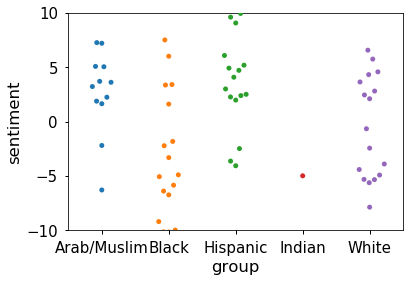

In [41]:
plot = seaborn.swarmplot(x='group', y='sentiment', data= name_sentiments)
plot.set_ylim([-10, 10])

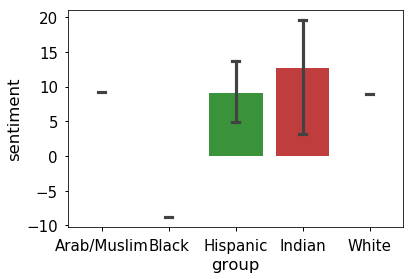

In [42]:
plot = seaborn.barplot(x='group', y='sentiment', data=name_sentiments, capsize=.1)

In [43]:
ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
ols_model.summary().tables[0]

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1348: RuntimeWarning: invalid value encountered in less
  term2 = np.where(denom < 0, term1, np.power((1-2.0/A)/denom, 1/3.0))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1366: RuntimeWarning: invalid value encountered in subtract
  weights=weights))**2)


Dep. Variable:,sentiment,R-squared:,nan
Model:,OLS,Adj. R-squared:,nan
Method:,Least Squares,F-statistic:,nan
Date:,"Thu, 22 Feb 2018",Prob (F-statistic):,nan
Time:,16:08:42,Log-Likelihood:,nan
No. Observations:,158,AIC:,nan
Df Residuals:,153,BIC:,nan
Df Model:,4,,
Covariance Type:,nonrobust,,


In [44]:
ols_model.fvalue

nan

In [45]:
def retrain_model(new_embs):
    """
    Repeat the steps above with a new set of word embeddings.
    """
    global model, embeddings, name_sentiments
    embeddings = new_embs
    pos_vectors = embeddings.loc[pos_words].dropna()
    neg_vectors = embeddings.loc[neg_words].dropna()
    vectors = pd.concat([pos_vectors, neg_vectors])
    targets = np.array([1 for entry in pos_vectors.index] + [-1 for entry in neg_vectors.index])
    labels = list(pos_vectors.index) + list(neg_vectors.index)

    train_vectors, test_vectors, train_targets, test_targets, train_labels, test_labels = \
        train_test_split(vectors, targets, labels, test_size=0.1, random_state=0)
        
    model = SGDClassifier(loss='log', random_state=0, n_iter=100)
    model.fit(train_vectors, train_targets)
    
    accuracy = accuracy_score(model.predict(test_vectors), test_targets)
    print("Accuracy of sentiment: {:.2%}".format(accuracy))
    
    name_sentiments = name_sentiment_table()
    ols_model = statsmodels.formula.api.ols('sentiment ~ group', data=name_sentiments).fit()
    print("F-value of bias: {:.3f}".format(ols_model.fvalue))
    print("Probability given null hypothesis: {:.3}".format(ols_model.f_pvalue))
    
    # Show the results on a swarm plot, with a consistent Y-axis
    plot = seaborn.swarmplot(x='group', y='sentiment', data=name_sentiments)
    plot.set_ylim([-10, 10])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


Accuracy of sentiment: 95.57%
F-value of bias: 15.594
Probability given null hypothesis: 1.03e-10


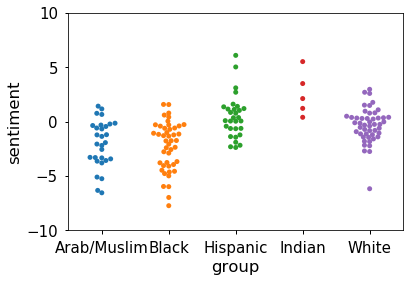

In [46]:
# Use a ConceptNet function to load word2vec into a Pandas frame from its binary format
from conceptnet5.vectors.formats import load_word2vec_bin
w2v = load_word2vec_bin('desktop\data/GoogleNews-vectors-negative300.bin.gz', nrows=2000000)

# word2vec is case-sensitive, so case-fold its labels
w2v.index = [label.casefold() for label in w2v.index]

# Now we have duplicate labels, so drop the later (lower-frequency) occurrences of the same label
w2v = w2v.reset_index().drop_duplicates(subset='index', keep='first').set_index('index')
retrain_model(w2v)

In [47]:
text_to_sentiment("sajan")

-0.4419372471361132

In [48]:
text_to_sentiment("sajan kumar")

0.7095759717128909

In [49]:
text_to_sentiment("sajan")

-0.4419372471361132

In [50]:
text_to_sentiment("shubham")

2.680521595286598

In [51]:
text_to_sentiment("sarvesh")

-1.1119731880616301